Import the libraries and format the data. Then display the data ontop of eachother. 

In [62]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
min_wage = pd.read_csv("federalMinimumWage.csv")
min_wage.columns = min_wage.columns.str.strip()

# Convert Effective Date → datetime
min_wage["Effective Date"] = (
    min_wage["Effective Date"]
    .astype(str)
    .str.strip()
)
min_wage["Effective Date"] = pd.to_datetime(
    min_wage["Effective Date"],
    format= "%b %d %Y",
    errors="coerce"
)

# Remove $ signs and convert to float
wage_cols = ["interstateWage", "stateWage", "nonFarmWage", "farmWage"]

for col in wage_cols:
    min_wage[col] = (
        min_wage[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .replace("0", np.nan)
        .astype(float)
    )

# Select the interstateWage as the federal wage, and readd it as a new column
min_wage["federalWage"] = min_wage["interstateWage"]

# Compute change in federal minimum wage
min_wage["wageChange"] = min_wage["federalWage"].diff()

# Optional: replace NaN for the first row with 0
min_wage["wageChange"] = min_wage["wageChange"].fillna(0)



In [ ]:
unemp = pd.read_csv("unemploymentRate.csv")
unemp.columns = unemp.columns.str.strip()

# Convert Effective Date → datetime
unemp["observation_date"] = (
    unemp["observation_date"]
    .astype(str)
    .str.strip()
)
unemp["observation_date"] = pd.to_datetime(
    unemp["observation_date"],
    format="%Y-%m-%d",
    errors="coerce"
)

# Convert unemployment rate to float
unemp["UNRATE"] = unemp["UNRATE"].astype(float)

# # Check data
# print("--- Column Names and Data Types Before Conversion ---")
# print(unemp.info())
# print("\n--- First 5 observation_date values (raw) ---")
# # Use .head(10) to see a few more, just in case the first few are bad
# print(unemp["observation_date"].head(5))


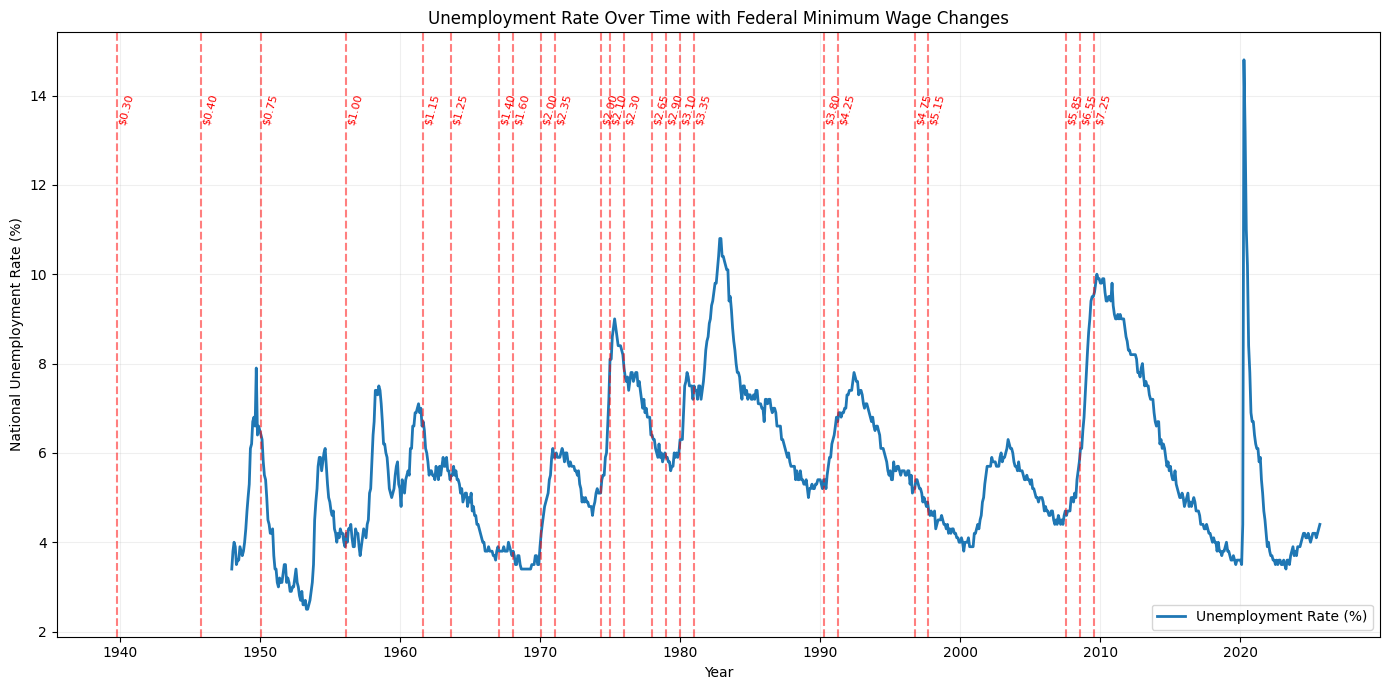

In [65]:
plt.figure(figsize=(14, 7))

# Change the data to only include rows where there was a change in minimum wage
mw_changes = min_wage[min_wage["wageChange"] != 0]

# Plot unemployment rate
plt.plot(
    unemp["observation_date"],
    unemp["UNRATE"],
    label="Unemployment Rate (%)",
    linewidth=2
)

# Add vertical lines for minimum wage changes
for idx, row in mw_changes.iterrows():
    date = row["Effective Date"]
    wage = row["federalWage"]
    plt.axvline(date, color="red", linestyle="--", alpha=0.5)
    plt.text(
        date,
        unemp["UNRATE"].max() * 0.95,  # place text near top
        f"${wage:.2f}",
        rotation=75,
        verticalalignment="top",
        fontsize=8,
        color="red"
    )


plt.title("Unemployment Rate Over Time with Federal Minimum Wage Changes")
plt.xlabel("Year")
plt.ylabel("National Unemployment Rate (%)")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()

plt.show()

In [70]:

# 1. Create "next wage change date" via shift
min_wage["next_change"] = min_wage["Effective Date"].shift(-1)

# 2. Compute "one year later" for each change
min_wage["one_year_later"] = min_wage["Effective Date"] + pd.DateOffset(years=1)

# 3. Target date = min(next_change, one_year_later), handling NaN properly
min_wage["target_date"] = min_wage[["one_year_later", "next_change"]].min(axis=1)

# 4. Merge unemployment ON OR AFTER wage-change date (BACKWARD=False selects nearest future)
unemp_after_change = pd.merge_asof(
    min_wage[["Effective Date"]],
    unemp,
    left_on="Effective Date",
    right_on="observation_date",
    direction="forward"
).rename(columns={"UNRATE": "current_unemp"})

# 5. Merge unemployment ON OR AFTER target date
unemp_after_target = pd.merge_asof(
    min_wage[["target_date"]],
    unemp,
    left_on="target_date",
    right_on="observation_date",
    direction="forward"
).rename(columns={"UNRATE": "future_unemp"})

# 6. Combine everything into a single dataframe
change_df = pd.concat(
    [
        min_wage[["Effective Date", "next_change", "one_year_later", "target_date"]],
        unemp_after_change["current_unemp"],
        unemp_after_target["future_unemp"]
    ],
    axis=1
)

# 7. Compute unemployment change
change_df["delta_unemp"] = change_df["future_unemp"] - change_df["current_unemp"]



# Show results

print(change_df.head(5))
print(change_df.tail(5))
print("\nAverage change in percent unemployment in the approximate year following each minimum wage change:")
print(change_df["delta_unemp"].mean())

  Effective Date next_change one_year_later target_date  current_unemp  \
0     1938-10-24  1939-10-24     1939-10-24  1939-10-24            3.4   
1     1939-10-24  1945-10-24     1940-10-24  1940-10-24            3.4   
2     1945-10-24  1950-01-25     1946-10-24  1946-10-24            3.4   
3     1950-01-25  1956-03-01     1951-01-25  1951-01-25            6.4   
4     1956-03-01  1961-09-03     1957-03-01  1957-03-01            4.2   

   future_unemp  delta_unemp  
0           3.4          0.0  
1           3.4          0.0  
2           3.4          0.0  
3           3.4         -3.0  
4           3.7         -0.5  
   Effective Date next_change one_year_later target_date  current_unemp  \
24     1996-10-01  1997-09-01     1997-10-01  1997-09-01            5.2   
25     1997-09-01  2007-07-24     1998-09-01  1998-09-01            4.9   
26     2007-07-24  2008-07-24     2008-07-24  2008-07-24            4.6   
27     2008-07-24  2009-07-24     2009-07-24  2009-07-24            6

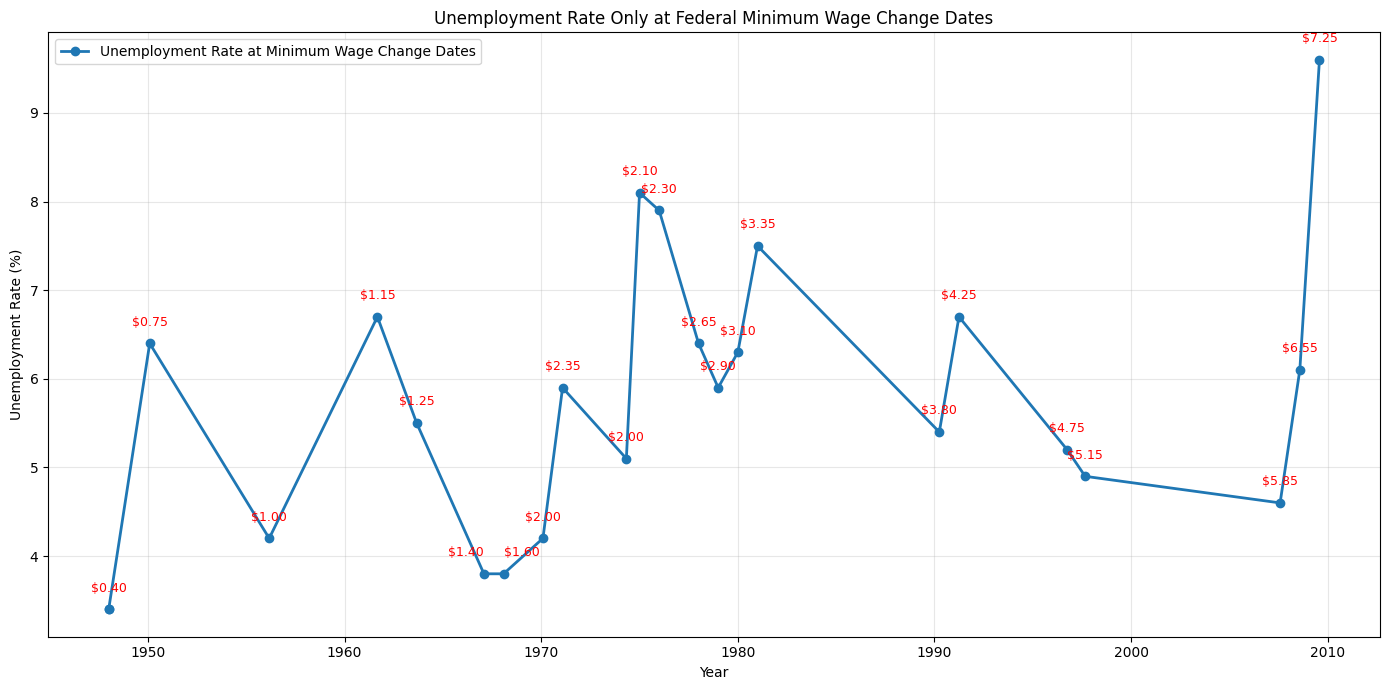

In [51]:
# Keep only real wage changes
mw_changes = min_wage[min_wage["wageChange"] != 0].copy()

# Merge each min wage change date with nearest unemployment observation
merged = pd.merge_asof(
    mw_changes.sort_values("Effective Date"),
    unemp.sort_values("observation_date"),
    left_on="Effective Date",
    right_on="observation_date",
    direction="nearest"
)

# Plot setup
plt.figure(figsize=(14, 7))

# Plot unemployment only at those points
plt.plot(
    merged["observation_date"],
    merged["UNRATE"],
    marker="o",
    linewidth=2,
    label="Unemployment Rate at Minimum Wage Change Dates"
)

# Annotate each point with the new minimum wage
for idx, row in merged.iterrows():
    alingment = "center"
    if row["federalWage"] == .30: continue
    if row["federalWage"] == 1.40: alingment = "right"
    if row["federalWage"] == 1.60: alingment = "left"
    plt.text(
        row["observation_date"],
        row["UNRATE"] + 0.2,
        f"${row['federalWage']:.2f}",
        ha=alingment,
        fontsize=9,
        color="red"
    )

plt.title("Unemployment Rate Only at Federal Minimum Wage Change Dates")
plt.xlabel("Year")
plt.ylabel("Federal Unemployment Rate (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# merged already contains the unemployment value for each min wage change date
# Make sure merged is sorted chronologically
# merged = merged.sort_values("observation_date").reset_index(drop=True)

# Compute next unemployment value after each change
merged["next_UNRATE"] = merged["UNRATE"].shift(-1)

# Compute the change in unemployment following the wage change
merged["delta_UNRATE"] = merged["next_UNRATE"] - merged["UNRATE"]

# Drop the last row (no next point)
merged_clean = merged.dropna(subset=["delta_UNRATE"])

# Compute the average change
average_change = merged_clean["delta_UNRATE"].mean()

print("Average change in percent unemployment after each minimum wage change until the next change:")
print(average_change)


Average change in percent unemployment after each minimum wage change until the next change:
0.2695652173913043
